# Milestone Project 2: SkimLit

The purpose of this notebook is to build NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

**Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the github:
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Get data

Since we're replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start the experiments with using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And on of the best ways to become one with the data is to...

> visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.


In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename_ a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f: return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read lines with the training files
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[
    {
        'line_number': 0,
        'target': 'BACKGROUND',
        'text': "Emotional eating is associated with overeating and the development of obesity.\n",
        'total_lines': 11
    }, 
    ...
]
```
Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modeling.

In [10]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line, 
  extracting things like the target label, the text of the sentence, 
  how many sentences are in the current abstract and what sentence 
  number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): ### for ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # will check if line is a new line?
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text in lowercase
        line_data["line_number"] = abstract_line_number # what number line doe the line appear in abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labeled sentence
      abstract_lines += line

  return abstract_samples



In [13]:
# Get data from file and preprocess it
%%time

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")# dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 411 ms, sys: 86.5 ms, total: 498 ms
Wall time: 499 ms


In [15]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [16]:
# now that data is in dictionaries, put in DataFrame to visualize it...
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)

test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [17]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

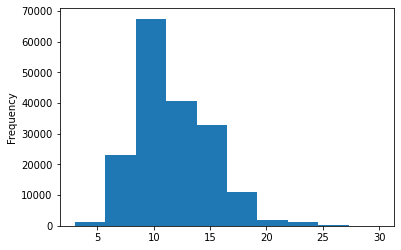

In [18]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [19]:
# Convert abstract lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [20]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numerical labels (ML models require numeric labels)

In [28]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))

val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [29]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [30]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modeling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline(
    [
        ("tf-idf", TfidfVectorizer()),
        ("clf", MultinomialNB())
    ]
)

# Fit the pipeline to the training data
model_0.fit(
    X=train_sentences,
    y=train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [34]:
# Evaluate baseline model on validation dataset
model_0.score(
    X=val_sentences,
    y=val_labels_encoded
)

0.7218323844829869

In [35]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In previous module, wrote a function to compare predictions across metrics (accuracy, precision, recall, and F1) and rather rewriting it here, let's download it from our helper function script: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [36]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-27 01:17:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-27 01:17:48 (91.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [37]:
from helper_functions import calculate_results

In [38]:
# Calculate baseline results
baseline_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=baseline_preds
)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [40]:
# How long is each sentence average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

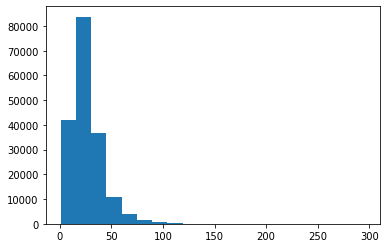

In [42]:
# What's the distribution look like?
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=20);

In [44]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [45]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

Create layer which will map text to numbers

In [46]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [47]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens= max_tokens, # number of words in vocab
    output_sequence_length = output_seq_len
) # desired output length of vectorized sequences



In [48]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [50]:
# Test our text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)

print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

# padded from 26 to 55... (hence the zeros...)

Text:
subjects self-administered the maximum tolerated dose of rw-sail ( n = @ ) or placebo ( n = @ ) daily beginning approximately @ to @ weeks before and through the end of the ragweed pollen season .

Length of text: 38

Vectorized text: [[  104  4139     2   635   580   131     4 28698    40    16    48    40
    161  1739  1048     6    53   129     3   313     2   199     4     2
  18061  5633  3964     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [51]:
# How many words in our training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

print(f"Number of words in vocab:\n{len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab:
64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [52]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [53]:
# Create token embedding layer
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab), # length of vocab
    output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters
    mask_zero=True, # use masking to handle variable sequence lengths (save space)
    name="token_embedding"
)

In [54]:
# Show example embedding
print(f"Sentences before vectorization:\n {target_sentence}\n")

vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")

embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shapes: {embedded_sentence.shape}")

Sentences before vectorization:
 subjects self-administered the maximum tolerated dose of rw-sail ( n = @ ) or placebo ( n = @ ) daily beginning approximately @ to @ weeks before and through the end of the ragweed pollen season .

Sentence after vectorization (before embedding):
 [[  104  4139     2   635   580   131     4 28698    40    16    48    40
    161  1739  1048     6    53   129     3   313     2   199     4     2
  18061  5633  3964     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.01026     0.04310635 -0.01921172 ...  0.03356991  0.02569158
   -0.04975041]
  [ 0.01043495  0.00237783  0.01507835 ... -0.01080369  0.01658278
   -0.02437223]
  [ 0.02575264  0.03752948  0.0351236  ... -0.01100178  0.02095738
    0.02481483]
  ...
  [ 0.02125635  0.02482338 -0.01705628 ...  0.0009497   0.00440846
    0.00967605]
  [ 0.02125

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [67]:
train_labels_one_hot.shape

(180040, 5)

In [69]:
train_labels_one_hot[0]

array([0., 0., 0., 1., 0.])

In [72]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])

In [73]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_sentences,
        train_labels_one_hot
    )
)

valid_dataset = tf.data.Dataset.from_tensor_slices(
    (
        val_sentences,
        val_labels_one_hot
    )
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        test_sentences,
        test_labels_one_hot
    )
)

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [74]:
# Take the TensorSliceDataset's and turn them into prefetced datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [75]:
# Create 1D conv model to process sequences

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorizes text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)



In [76]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [78]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [79]:
len(train_dataset)

5627

In [80]:
# Fit the model
history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1*len(valid_dataset)) # only validate on 10% of batches

)

Epoch 1/3
562/562 [==============================] - 5s 8ms/step - loss: 0.5225 - accuracy: 0.8167 - val_loss: 0.5881 - val_accuracy: 0.7932
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.4599 - accuracy: 0.8391 - val_loss: 0.5939 - val_accuracy: 0.7879
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.4449 - accuracy: 0.8439 - val_loss: 0.6014 - val_accuracy: 0.7789


In [81]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6049 - accuracy: 0.7843


[0.6049293875694275, 0.7842578887939453]

In [82]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[5.2916467e-01, 1.2546934e-01, 8.9185514e-02, 2.1654136e-01,
        3.9639030e-02],
       [4.0455803e-01, 2.5394273e-01, 1.8930383e-02, 3.1767446e-01,
        4.8943353e-03],
       [8.6976379e-02, 1.0637918e-03, 3.2328922e-04, 9.1163528e-01,
        1.1921085e-06],
       ...,
       [2.5155913e-07, 4.4837569e-05, 6.9920468e-05, 8.9030394e-08,
        9.9988484e-01],
       [8.3559103e-02, 4.8755500e-01, 7.0278578e-02, 5.9456740e-02,
        2.9915053e-01],
       [3.2005355e-02, 9.3870872e-01, 8.9271767e-03, 3.7992634e-03,
        1.6559510e-02]], dtype=float32)

In [83]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [84]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.42579107639348,
 'precision': 0.7818008246396494,
 'recall': 0.7842579107639348,
 'f1': 0.7824869763362102}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE):
https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.


In [85]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="universal_sentence_encoder"
)

In [86]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
a cohort of @ women with severe postpartum anaemia ( @-@ @ g/dl ) treated with oral ferrous sulphate ( two tablets of @mg ) .

Sentence after embedding:
[-0.02549344  0.03489412  0.0444395  -0.05948545 -0.03186247 -0.01274868
  0.0423019   0.0098716   0.04547294  0.05937583  0.07905243  0.02184987
 -0.02421694  0.02940663 -0.05450834  0.00309095 -0.08003447  0.0075207
 -0.01951246  0.05793423 -0.02703085  0.05598299 -0.05104369  0.01653278
 -0.03396606  0.02128259  0.06275714 -0.03621532 -0.04326136  0.02562381] (truncated output)...

Length of sentence embedding:
512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [88]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(
    inputs=inputs,
    outputs=outputs,
    name="model_2_USE_feature_extractor"
)

# Compile the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [89]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [90]:
# Fit feature extractor model for 3 epochs
model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)), # 10% of batches
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9166 - accuracy: 0.6490 - val_loss: 0.7980 - val_accuracy: 0.6928
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7687 - accuracy: 0.7025 - val_loss: 0.7549 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7519 - accuracy: 0.7118 - val_loss: 0.7380 - val_accuracy: 0.7138


In [91]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7411 - accuracy: 0.7125


[0.741129457950592, 0.712465226650238]

In [92]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.2244956e-01, 3.8179293e-01, 2.7660008e-03, 1.8517429e-01,
        7.8172274e-03],
       [3.5068193e-01, 5.1568055e-01, 3.0446225e-03, 1.2804665e-01,
        2.5462292e-03],
       [2.4782781e-01, 1.4853317e-01, 2.0453725e-02, 5.4200286e-01,
        4.1182440e-02],
       ...,
       [1.7856174e-03, 6.4863828e-03, 5.3867359e-02, 8.4064645e-04,
        9.3702000e-01],
       [4.1694455e-03, 4.9920268e-02, 2.0451193e-01, 1.3488090e-03,
        7.4004954e-01],
       [1.5558772e-01, 2.5615922e-01, 5.2525061e-01, 9.6699921e-03,
        5.3332493e-02]], dtype=float32)

In [93]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [94]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.24652455977757,
 'precision': 0.7124338714158726,
 'recall': 0.7124652455977757,
 'f1': 0.7092580750271058}

In [95]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [96]:
model_1_results

{'accuracy': 78.42579107639348,
 'precision': 0.7818008246396494,
 'recall': 0.7842579107639348,
 'f1': 0.7824869763362102}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've used token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.


### Creating a character-level tokenizer

In [97]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [98]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'a   c o h o r t   o f   @   w o m e n   w i t h   s e v e r e   p o s t p a r t u m   a n a e m i a   (   @ - @   @   g / d l   )   t r e a t e d   w i t h   o r a l   f e r r o u s   s u l p h a t e   (   t w o   t a b l e t s   o f   @ m g   )   .'

In [100]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [101]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

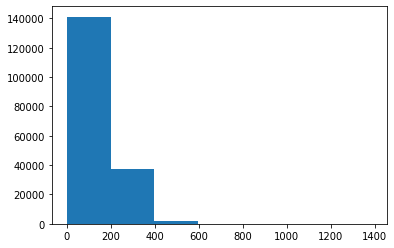

In [102]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [103]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [104]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [105]:
random.choice(train_sentences)

'seventy six participants aged @ to @ years with fd as diagnosed by rome iii criteria will be recruited from august @ to january @ at two korean medicine hospitals .'

In [107]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,  
    output_sequence_length=output_seq_char_len,
    standardize="lower_and_strip_punctuation",
    name="char_vectorizer"
)

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [108]:
# Check character vocabulary stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [109]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e y   w e r e   r a n d o m l y   d i v i d e d   i n t o   m s m   g r o u p   o r   t c t   g r o u p   a n d   t h e n   p a i n   a t   r e d u c t i o n   ,   t i m e   o f   r e d u c t i o n   ,   d u r a t i o n   o f   h o s p i t a l i z a t i o n   ,   a n d   s u c c e s s   r a t e   w e r e   c o m p a r e d   .

Length of random_train_chars: 137

Vectorized chars:
[[ 3 13  2 19 20  2  8  2  8  5  6 10  7 15 12 19 10  4 21  4 10  2 10  4
   6  3  7 15  9 15 18  8  7 16 14  7  8  3 11  3 18  8  7 16 14  5  6 10
   3 13  2  6 14  5  4  6  5  3  8  2 10 16 11  3  4  7  6  3  4 15  2  7
  17  8  2 10 16 11  3  4  7  6 10 16  8  5  3  4  7  6  7 17 13  7  9 14
   4  3  5 12  4 25  5  3  4  7  6  5  6 10  9 16 11 11  2  9  9  8  5  3
   2 20  2  8  2 11  7 15 14  5  8  2 10  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  

### Creating a character-level embedding

In [111]:
char_embed = layers.Embedding(
    input_dim=NUM_CHAR_TOKENS, # number of different characters
    output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
    mask_zero=False, # don't use masks (this messes up model_5 if set to True)
    name="char_embed"
)

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e y   w e r e   r a n d o m l y   d i v i d e d   i n t o   m s m   g r o u p   o r   t c t   g r o u p   a n d   t h e n   p a i n   a t   r e d u c t i o n   ,   t i m e   o f   r e d u c t i o n   ,   d u r a t i o n   o f   h o s p i t a l i z a t i o n   ,   a n d   s u c c e s s   r a t e   w e r e   c o m p a r e d   .

Embedded chars (after vectorization and embedding):
[[[-0.00318388 -0.01209218  0.02763538 ...  0.00465063 -0.02030789
   -0.04519274]
  [ 0.04147055  0.04962671 -0.03374116 ...  0.00292839  0.03332925
    0.00748442]
  [ 0.01091571  0.03829688  0.03375372 ... -0.00932112 -0.02070621
   -0.04627962]
  ...
  [ 0.04804583 -0.02829321 -0.0129115  ...  0.00974382  0.04071869
   -0.01669329]
  [ 0.04804583 -0.02829321 -0.0129115  ...  0.00974382  0.04071869
   -0.01669329]
  [ 0.04804583 -0.02829321 -0.0129115  ...  0.00974382  0.04071869
   -0.01669329]]]

Character embedding shape: (1, 290, 25)


In [112]:
len(random_train_chars)

331

### Building a Conv1Dmodel to fit on character embeddings

In [113]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(
    inputs=inputs,
    outputs=outputs,
    name="model_3_conv1D_char_embedding"
)

# Compile model
model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [114]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 5

In [115]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [116]:
# Fit the model on chars only
model_3_history = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2752 - accuracy: 0.4862 - val_loss: 1.0571 - val_accuracy: 0.5721
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0111 - accuracy: 0.5962 - val_loss: 0.9432 - val_accuracy: 0.6287
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9260 - accuracy: 0.6363 - val_loss: 0.8703 - val_accuracy: 0.6556


In [117]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8836 - accuracy: 0.6572


[0.8836309909820557, 0.6572222709655762]

In [118]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.2733918 , 0.2930737 , 0.04337063, 0.32734543, 0.06281848],
       [0.15550284, 0.62632024, 0.02249466, 0.14941815, 0.04626417],
       [0.20892774, 0.13547444, 0.11682403, 0.49783775, 0.04093599],
       ...,
       [0.04545256, 0.09306119, 0.1283003 , 0.06013055, 0.6730554 ],
       [0.02794293, 0.09871335, 0.39835456, 0.02503746, 0.44995162],
       [0.4427278 , 0.26834148, 0.1555529 , 0.12597734, 0.00740046]],
      dtype=float32)

In [119]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 0])>

In [120]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.72222957765128,
 'precision': 0.6469572038323705,
 'recall': 0.6572222957765127,
 'f1': 0.6456730248292187}

In [121]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Combine (using `layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.23 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [122]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(
    inputs=token_inputs,
    outputs=token_output
)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(
    inputs=char_inputs,
    outputs=char_bi_lstm
)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")(
    [
        token_model.output, 
        char_model.output
    ]
)

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=output_layer,
    name="model_4_token_and_char_embeddings"
)

In [123]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

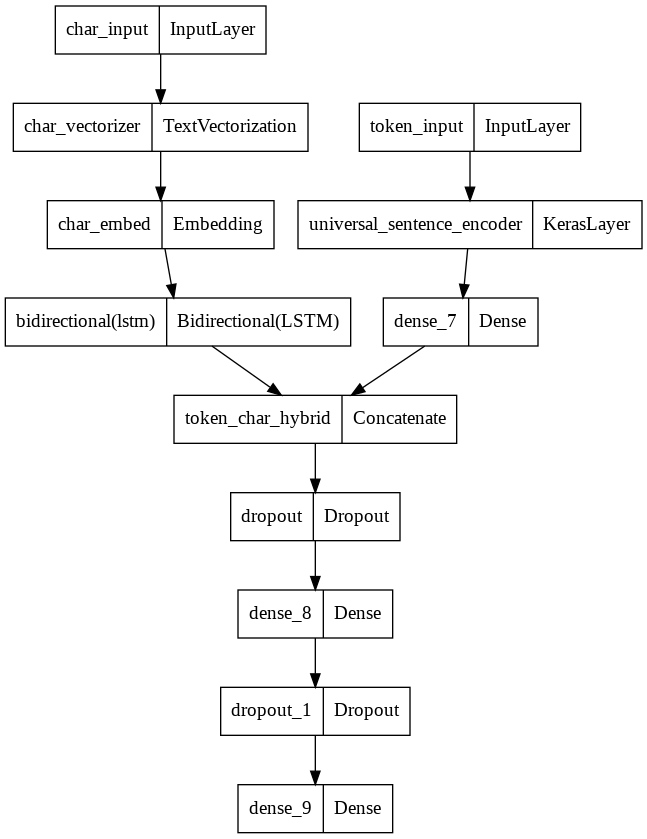

In [124]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [125]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [126]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [127]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [128]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(
    train_char_token_dataset, # train on dataset of token and characters
    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
    epochs=3,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1 * len(val_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 25s 37ms/step - loss: 0.9729 - accuracy: 0.6110 - val_loss: 0.7807 - val_accuracy: 0.6995
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.7946 - accuracy: 0.6933 - val_loss: 0.7134 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7677 - accuracy: 0.7038 - val_loss: 0.6893 - val_accuracy: 0.7390


In [129]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6941 - accuracy: 0.7332


[0.6941222548484802, 0.7331854701042175]

In [130]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 21s 22ms/step


array([[4.3305859e-01, 3.9706388e-01, 3.1013072e-03, 1.5917374e-01,
        7.6024411e-03],
       [2.9847944e-01, 5.3620017e-01, 2.7009025e-03, 1.6095573e-01,
        1.6637578e-03],
       [2.1025147e-01, 5.2878402e-02, 3.0366605e-02, 6.8705893e-01,
        1.9444654e-02],
       ...,
       [7.4551255e-04, 9.9185966e-03, 5.0440606e-02, 2.2443877e-04,
        9.3867087e-01],
       [8.5924491e-03, 7.7133231e-02, 1.5401912e-01, 4.4894880e-03,
        7.5576574e-01],
       [4.1601351e-01, 3.2711348e-01, 1.6963522e-01, 4.7017328e-02,
        4.0220421e-02]], dtype=float32)

In [131]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [133]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_4_preds
)

model_4_results

{'accuracy': 73.31854892095856,
 'precision': 0.7337337764094242,
 'recall': 0.7331854892095856,
 'f1': 0.7301187067931308}

In [134]:
model_1_results

{'accuracy': 78.42579107639348,
 'precision': 0.7818008246396494,
 'recall': 0.7842579107639348,
 'f1': 0.7824869763362102}

In [135]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [136]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [137]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

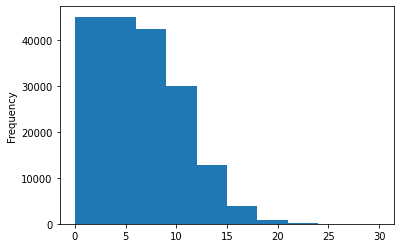

In [138]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [139]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [140]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

Now we've encoded our line numbers features, let's do the same our total lines feature...

In [141]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

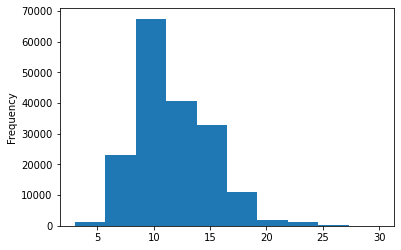

In [142]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [143]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [144]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model fro the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [147]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(
    inputs=char_inputs,
    outputs=char_bi_lstm
)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(
    inputs=line_number_inputs,
    outputs=x
)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(
    inputs=total_lines_inputs,
    outputs=y
)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")(
    [
        token_model.output, 
        char_model.output
    ]
)

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")(
    [
        line_number_model.output,
        total_line_model.output,
        z
    ]
)

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(
    inputs=[
        line_number_model.input,
        total_line_model.input,
        token_model.input, 
        char_model.input
    ],
    outputs=output_layer,
    name="tribrid_embedding_model"
)

In [148]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

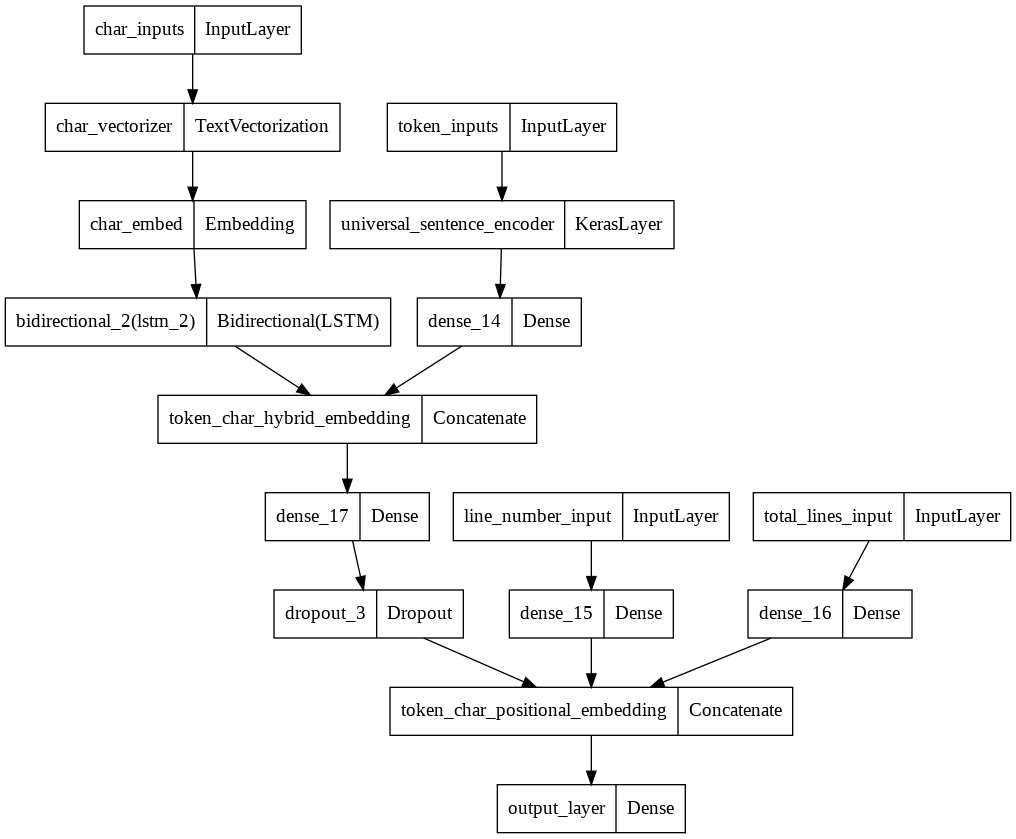

In [149]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [150]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe52f4c4fa0> True
<keras.engine.input_layer.InputLayer object at 0x7fe52f3d92b0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fe45722a7c0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fe51a2d6700> False
<keras.layers.core.embedding.Embedding object at 0x7fe457209d00> True
<keras.layers.core.dense.Dense object at 0x7fe52f3f80a0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7fe52f350bb0> True
<keras.layers.merging.concatenate.Concatenate object at 0x7fe52f2948b0> True
<keras.engine.input_layer.InputLayer object at 0x7fe52f24b250> True
<keras.engine.input_layer.InputLayer object at 0x7fe52fecec10> True
<keras.layers.core.dense.Dense object at 0x7fe52f3654f0> True
<keras.layers.core.dense.Dense object at 0x7fe52f3fbb50> True
<keras.layers.core.dense.Dense object at 0x7fe52f382730> True
<keras.layers.regularization.dropout.Dropout object at 0x7fe52f3a5070> True
<keras.layers

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> for more on label smoothing, see this blog post from PyImageSearch:
[*Label smoothing with Keras, TensorFlow, and Deep Learning.*](https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/)

In [151]:
# Compile token, char, positional embedding model
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Create tribrid embedding datasets using tf.data

In [152]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices(
    (
        train_line_numbers_one_hot, # line numbers
        train_total_lines_one_hot, # total lines
        train_sentences, # train tokens
        train_chars
    )
) # train chars

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices(
    (
        val_line_numbers_one_hot,
        val_total_lines_one_hot,
        val_sentences,
        val_chars
    )
)

val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [153]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(
    train_pos_char_token_dataset,
    steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
    epochs=3,
    validation_data=val_pos_char_token_dataset,
    validation_steps=int(0.1 * len(val_pos_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 26s 40ms/step - loss: 1.0950 - accuracy: 0.7237 - val_loss: 0.9817 - val_accuracy: 0.8029
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9672 - accuracy: 0.8150 - val_loss: 0.9502 - val_accuracy: 0.8298
Epoch 3/3
562/562 [==============================] - 22s 38ms/step - loss: 0.9515 - accuracy: 0.8214 - val_loss: 0.9385 - val_accuracy: 0.8298


In [154]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 22s 22ms/step


array([[0.5053246 , 0.11432419, 0.00986453, 0.3555694 , 0.01491731],
       [0.54542786, 0.09101005, 0.0536482 , 0.29753855, 0.01237533],
       [0.2920827 , 0.09614607, 0.10933732, 0.44879952, 0.05363444],
       ...,
       [0.03392679, 0.10783698, 0.04100505, 0.03349296, 0.7837382 ],
       [0.02988404, 0.31646863, 0.07821644, 0.02473365, 0.5506972 ],
       [0.23433535, 0.56039476, 0.09457137, 0.04545228, 0.06524625]],
      dtype=float32)

In [155]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [156]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.17555938037866,
 'precision': 0.8306059610021649,
 'recall': 0.8317555938037866,
 'f1': 0.8309221938161986}

In [157]:
model_4_results

{'accuracy': 73.31854892095856,
 'precision': 0.7337337764094242,
 'recall': 0.7331854892095856,
 'f1': 0.7301187067931308}

In [158]:
model_1_results

{'accuracy': 78.42579107639348,
 'precision': 0.7818008246396494,
 'recall': 0.7842579107639348,
 'f1': 0.7824869763362102}

In [159]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Compare model results

In [164]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame(
    {
        "baseline": baseline_results,
        "custom_token_embed_conv1d": model_1_results,
        "pretrained_token_embed": model_2_results,
        "custom_char_embed_conv1d": model_3_results,
        "hybrid_char_token_embed": model_4_results,
        "tribrid_pos_char_token_embed": model_5_results
    }
)

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.425791,0.781801,0.784258,0.782487
pretrained_token_embed,71.246525,0.712434,0.712465,0.709258
custom_char_embed_conv1d,65.722230,0.646957,0.657222,0.645673
hybrid_char_token_embed,73.318549,0.733734,0.733185,0.730119
tribrid_pos_char_token_embed,83.175559,0.830606,0.831756,0.830922


In [165]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

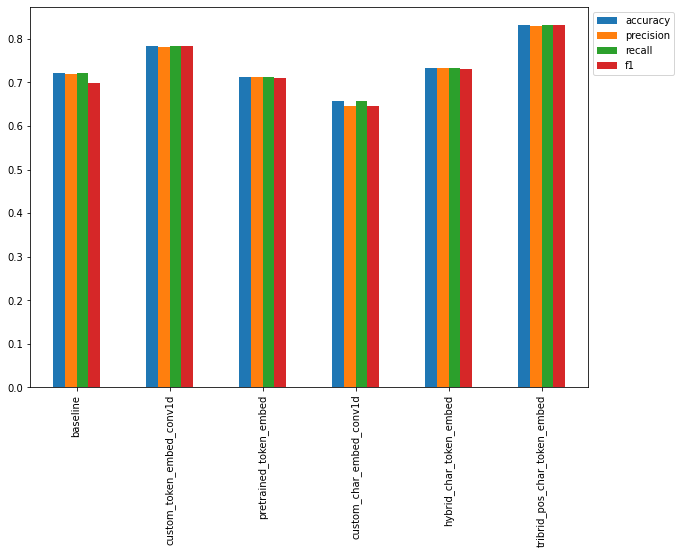

In [166]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

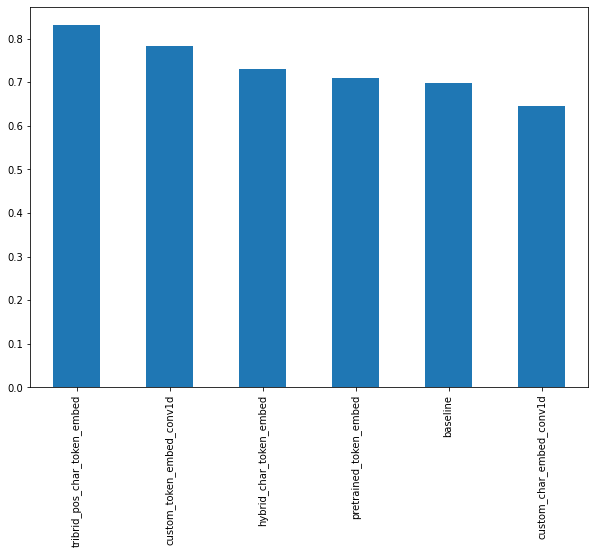

In [167]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Save and load best performing model

In [168]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [169]:
# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
# !cp skim_lit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit

In [170]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2022-12-27 05:25:33--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  22.9MB/s    in 41s     

2022-12-27 05:26:15 (22.3 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_met

more left... (check notebook)
